# JEE Cutoff Prediction Model
## Phase 3: Model Building and Training

**Objective**: Build and train XGBoost model to predict JEE cutoffs

**Key Tasks**:
- Load feature-engineered data
- Split data using time-series approach
- Train XGBoost model
- Hyperparameter tuning
- Evaluate model performance
- Analyze feature importance

**Course Alignment**: 
- Unit 4: Regression
- Unit 5: Ensemble Learning (XGBoost)

## Step 1: Import Libraries

In [130]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

✅ Libraries imported successfully!
XGBoost version: 3.1.1


## Step 2: Load Feature-Engineered Data

In [131]:
# Load the model-ready dataset
df = pd.read_csv('cutoffs_model_ready.csv')

print("✅ Data loaded successfully!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nFirst few rows:")
print(df.head())

# Load feature names
feature_info = pd.read_csv('feature_names.csv')
feature_columns = feature_info['feature_name'].tolist()

print(f"\n📋 Total features for modeling: {len(feature_columns)}")
print(f"\n✓ Feature list loaded from Phase 2")

✅ Data loaded successfully!
📊 Shape: 78807 rows × 25 columns

First few rows:
   institute_encoded  branch_encoded  quota_encoded  seat_type_encoded  \
0                  0               1              0                  0   
1                  0               1              0                  0   
2                  0               1              0                  0   
3                  0               1              0                  0   
4                  0               1              0                  0   

   gender_encoded  branch_demand_category_encoded  cutoff_prev_1yr  \
0               1                               1     11985.038462   
1               1                               1      7839.000000   
2               1                               1     11172.000000   
3               1                               1     13870.000000   
4               1                               1     13007.000000   

   cutoff_prev_2yr  cutoff_prev_3yr  cutoff_mean_3yr  cu

## Step 3: Prepare Features and Target

Separate features (X) and target variable (y)

In [132]:
# Define features and target
X = df[feature_columns].copy()
y = df['cutoff'].copy()

# Keep metadata for later analysis
metadata = df[['seat_id', 'institute', 'branch']].copy()

print("✅ Features and target prepared!")
print(f"\n📊 Feature matrix (X) shape: {X.shape}")
print(f"📊 Target vector (y) shape: {y.shape}")
print(f"\n📈 Target variable statistics:")
print(y.describe())

✅ Features and target prepared!

📊 Feature matrix (X) shape: (78807, 21)
📊 Target vector (y) shape: (78807,)

📈 Target variable statistics:
count     78807.000000
mean      11667.006979
std       19790.844322
min           1.000000
25%        1377.000000
50%        4494.000000
75%       12581.500000
max      199827.000000
Name: cutoff, dtype: float64


## Step 4: Extract Year Information

Get the year column for time-series splitting (must be done before train-test split)

In [133]:
# Get year column for splitting (save before any data manipulation)
years = df['year'].copy()

print("✅ Year information extracted!")
print(f"\n📊 Year distribution:")
print(years.value_counts().sort_index())

✅ Year information extracted!

📊 Year distribution:
year
2018     7076
2019     8649
2020     9246
2021     9368
2022     9955
2023    10761
2024    11582
2025    12170
Name: count, dtype: int64


## Step 5: Check for Missing Values and Handle Them

Before training, we need to check and handle any missing values in the data

In [134]:
# Check for missing values in the entire dataset
print("🔍 Checking for missing values...")
print("\n" + "="*80)
print("📊 MISSING VALUES IN DATASET")
print("="*80)

missing_before = X.isnull().sum()
missing_features = missing_before[missing_before > 0]

if len(missing_features) > 0:
    print(f"\n⚠️  Found {len(missing_features)} features with missing values:")
    for feature, count in missing_features.items():
        pct = (count / len(X)) * 100
        print(f"  {feature}: {count:,} missing ({pct:.2f}%)")
    
    print(f"\n🔄 Handling missing values...")
    
    # Fill missing values with median for numeric features
    # This is safe for our use case (lag features, statistical features)
    for col in missing_features.index:
        median_value = X[col].median()
        X[col].fillna(median_value, inplace=True)
        print(f"  ✓ Filled {col} with median: {median_value:.2f}")
    
    # Verify no more missing values
    missing_after = X.isnull().sum().sum()
    print(f"\n✅ Missing values handled!")
    print(f"  Before: {missing_before.sum():,} missing values")
    print(f"  After: {missing_after} missing values")
else:
    print("\n✅ No missing values found!")

print("="*80)

🔍 Checking for missing values...

📊 MISSING VALUES IN DATASET

⚠️  Found 3 features with missing values:
  cutoff_prev_1yr: 125 missing (0.16%)
  cutoff_prev_2yr: 417 missing (0.53%)
  cutoff_prev_3yr: 978 missing (1.24%)

🔄 Handling missing values...
  ✓ Filled cutoff_prev_1yr with median: 5336.47
  ✓ Filled cutoff_prev_2yr with median: 5812.23
  ✓ Filled cutoff_prev_3yr with median: 5567.03

✅ Missing values handled!
  Before: 1,520 missing values
  After: 0 missing values


## Step 6: Time-Series Train-Test Split

**Important**: We use time-based split, NOT random split!
- Train: 2018-2023 (6 years)
- Test: 2024 (1 year)

This prevents data leakage (using future data to predict past)

In [135]:
# Time-based split: Train on 2018-2023, Test on 2024
train_mask = years < 2024
test_mask = years == 2024

X_train = X[train_mask].copy()
y_train = y[train_mask].copy()
X_test = X[test_mask].copy()
y_test = y[test_mask].copy()

# Metadata for analysis
train_metadata = metadata[train_mask].copy()
test_metadata = metadata[test_mask].copy()

print("✅ Time-series split completed!")
print(f"\n📊 Training set:")
print(f"  - Years: {years[train_mask].min()} to {years[train_mask].max()}")
print(f"  - Samples: {len(X_train):,}")
print(f"  - Shape: {X_train.shape}")

print(f"\n📊 Test set:")
print(f"  - Year: {years[test_mask].unique()[0]}")
print(f"  - Samples: {len(X_test):,}")
print(f"  - Shape: {X_test.shape}")

print(f"\n📈 Train-Test split ratio: {len(X_train)/len(X)*100:.1f}% - {len(X_test)/len(X)*100:.1f}%")

# Final check for NaN values in train and test sets
print(f"\n🔍 Final data quality check:")
print(f"  - NaN in X_train: {X_train.isnull().sum().sum()}")
print(f"  - NaN in X_test: {X_test.isnull().sum().sum()}")
print(f"  - NaN in y_train: {y_train.isnull().sum()}")
print(f"  - NaN in y_test: {y_test.isnull().sum()}")

✅ Time-series split completed!

📊 Training set:
  - Years: 2018 to 2023
  - Samples: 55,055
  - Shape: (55055, 21)

📊 Test set:
  - Year: 2024
  - Samples: 11,582
  - Shape: (11582, 21)

📈 Train-Test split ratio: 69.9% - 14.7%

🔍 Final data quality check:
  - NaN in X_train: 0
  - NaN in X_test: 0
  - NaN in y_train: 0
  - NaN in y_test: 0


## Step 6.5: Data Quality Validation - Check for Invalid Ranks

**Safety Check**: Verify that Phase 1 cleaning removed all invalid ranks.

JEE has ~1.2 million test takers. Ranks > 1.5 million indicate data errors.

**Note**: This should already be handled in Phase 1, but we verify here as a safety check.

In [136]:
print("SAFETY CHECK: Verifying data quality...")
print("="*80)

# Define maximum valid rank (JEE has ~1.2 million test takers)
MAX_VALID_RANK = 200_000

# Check both train and test sets
print(f"\nCutoff statistics:")
print(f"Training set:")
print(f"  Min: {y_train.min():,.0f}")
print(f"  Max: {y_train.max():,.0f}")
print(f"  Mean: {y_train.mean():,.0f}")
print(f"  Median: {y_train.median():,.0f}")
print(f"  Ranks > {MAX_VALID_RANK:,}: {(y_train > MAX_VALID_RANK).sum():,}")

print(f"\nTest set:")
print(f"  Min: {y_test.min():,.0f}")
print(f"  Max: {y_test.max():,.0f}")
print(f"  Mean: {y_test.mean():,.0f}")
print(f"  Median: {y_test.median():,.0f}")
print(f"  Ranks > {MAX_VALID_RANK:,}: {(y_test > MAX_VALID_RANK).sum():,}")

# Check for invalid rows
invalid_train = y_train > MAX_VALID_RANK
invalid_test = y_test > MAX_VALID_RANK

if invalid_train.sum() > 0 or invalid_test.sum() > 0:
    print(f"\nWARNING: Found INVALID ranks (> {MAX_VALID_RANK:,})!")
    print(f"   This means Phase 1 data cleaning didn't run properly.")
    print(f"\nInvalid entries by institute:")
    
    if invalid_train.sum() > 0:
        print(f"\nTraining set ({invalid_train.sum()} invalid):")
        invalid_train_data = pd.DataFrame({
            'institute': train_metadata.loc[invalid_train, 'institute'],
            'branch': train_metadata.loc[invalid_train, 'branch'],
            'rank': y_train[invalid_train]
        })
        print(invalid_train_data.groupby('institute')['rank'].agg(['count', 'min', 'max']))
    
    if invalid_test.sum() > 0:
        print(f"\nTest set ({invalid_test.sum()} invalid):")
        invalid_test_data = pd.DataFrame({
            'institute': test_metadata.loc[invalid_test, 'institute'],
            'branch': test_metadata.loc[invalid_test, 'branch'],
            'rank': y_test[invalid_test]
        })
        print(invalid_test_data.groupby('institute')['rank'].agg(['count', 'min', 'max']))
    
    print(f"\nRemoving invalid entries from training data...")
    
    # Filter out invalid data
    X_train = X_train[~invalid_train]
    y_train = y_train[~invalid_train]
    train_metadata = train_metadata[~invalid_train]
    
    X_test = X_test[~invalid_test]
    y_test = y_test[~invalid_test]
    test_metadata = test_metadata[~invalid_test]
    
    print(f"\nInvalid entries removed!")
    print(f"  Training: {len(X_train):,} samples (removed {invalid_train.sum():,})")
    print(f"  Test: {len(X_test):,} samples (removed {invalid_test.sum():,})")
    
    print(f"\nRECOMMENDATION: Re-run Phase 1 (main.ipynb) to clean data at source!")
else:
    print(f"\nEXCELLENT! All ranks are valid (<= {MAX_VALID_RANK:,})")
    print(f"   Phase 1 data cleaning worked properly!")

print("="*80)

SAFETY CHECK: Verifying data quality...

Cutoff statistics:
Training set:
  Min: 1
  Max: 199,638
  Mean: 11,220
  Median: 4,280
  Ranks > 200,000: 0

Test set:
  Min: 1
  Max: 198,857
  Mean: 12,386
  Median: 4,934
  Ranks > 200,000: 0

EXCELLENT! All ranks are valid (<= 200,000)
   Phase 1 data cleaning worked properly!


## Step 7: Baseline Model - Simple Linear Regression

Create a baseline to compare XGBoost performance against

In [137]:
from sklearn.linear_model import LinearRegression

print("🔄 Training baseline Linear Regression model...")

# Train simple linear regression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = baseline_model.predict(X_train)
y_test_pred_baseline = baseline_model.predict(X_test)

# Evaluate baseline
train_mae_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
test_mae_baseline = mean_absolute_error(y_test, y_test_pred_baseline)
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
test_rmse_baseline = np.sqrt(mean_squared_error(y_test, y_test_pred_baseline))
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
test_r2_baseline = r2_score(y_test, y_test_pred_baseline)

print("\n✅ Baseline model trained!")
print("\n" + "="*80)
print("📊 BASELINE MODEL PERFORMANCE (Linear Regression)")
print("="*80)
print(f"\nTraining Set:")
print(f"  MAE:  {train_mae_baseline:,.2f} ranks")
print(f"  RMSE: {train_rmse_baseline:,.2f} ranks")
print(f"  R²:   {train_r2_baseline:.4f}")

print(f"\nTest Set (2024):")
print(f"  MAE:  {test_mae_baseline:,.2f} ranks")
print(f"  RMSE: {test_rmse_baseline:,.2f} ranks")
print(f"  R²:   {test_r2_baseline:.4f}")
print("="*80)

🔄 Training baseline Linear Regression model...

✅ Baseline model trained!

📊 BASELINE MODEL PERFORMANCE (Linear Regression)

Training Set:
  MAE:  4,814.89 ranks
  RMSE: 10,745.04 ranks
  R²:   0.6913

Test Set (2024):
  MAE:  3,825.57 ranks
  RMSE: 8,230.11 ranks
  R²:   0.8322

✅ Baseline model trained!

📊 BASELINE MODEL PERFORMANCE (Linear Regression)

Training Set:
  MAE:  4,814.89 ranks
  RMSE: 10,745.04 ranks
  R²:   0.6913

Test Set (2024):
  MAE:  3,825.57 ranks
  RMSE: 8,230.11 ranks
  R²:   0.8322


## Step 8: Build Initial XGBoost Model

Train XGBoost with default parameters first

In [138]:
print("🔄 Training initial XGBoost model...\n")

# Create XGBoost regressor with initial parameters
xgb_initial = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression task
    n_estimators=100,               # Number of trees
    max_depth=6,                    # Tree depth
    learning_rate=0.1,              # Learning rate
    random_state=42,
    n_jobs=-1,                      # Use all CPU cores
    eval_metric='mae'               # Evaluation metric
)

# Train the model
xgb_initial.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predictions
y_train_pred_initial = xgb_initial.predict(X_train)
y_test_pred_initial = xgb_initial.predict(X_test)

# Evaluate
train_mae_initial = mean_absolute_error(y_train, y_train_pred_initial)
test_mae_initial = mean_absolute_error(y_test, y_test_pred_initial)
train_rmse_initial = np.sqrt(mean_squared_error(y_train, y_train_pred_initial))
test_rmse_initial = np.sqrt(mean_squared_error(y_test, y_test_pred_initial))
train_r2_initial = r2_score(y_train, y_train_pred_initial)
test_r2_initial = r2_score(y_test, y_test_pred_initial)

print("✅ Initial XGBoost model trained!")
print("\n" + "="*80)
print("📊 INITIAL XGBOOST PERFORMANCE (Default Parameters)")
print("="*80)
print(f"\nTraining Set:")
print(f"  MAE:  {train_mae_initial:,.2f} ranks")
print(f"  RMSE: {train_rmse_initial:,.2f} ranks")
print(f"  R²:   {train_r2_initial:.4f}")

print(f"\nTest Set (2024):")
print(f"  MAE:  {test_mae_initial:,.2f} ranks")
print(f"  RMSE: {test_rmse_initial:,.2f} ranks")
print(f"  R²:   {test_r2_initial:.4f}")

print(f"\n💡 Improvement over baseline:")
print(f"  MAE improvement: {test_mae_baseline - test_mae_initial:,.2f} ranks ({(test_mae_baseline - test_mae_initial)/test_mae_baseline*100:.1f}%)")
print(f"  RMSE improvement: {test_rmse_baseline - test_rmse_initial:,.2f} ranks ({(test_rmse_baseline - test_rmse_initial)/test_rmse_baseline*100:.1f}%)")
print("="*80)

🔄 Training initial XGBoost model...

✅ Initial XGBoost model trained!

📊 INITIAL XGBOOST PERFORMANCE (Default Parameters)

Training Set:
  MAE:  1,940.88 ranks
  RMSE: 4,855.94 ranks
  R²:   0.9369

Test Set (2024):
  MAE:  2,270.39 ranks
  RMSE: 6,146.87 ranks
  R²:   0.9064

💡 Improvement over baseline:
  MAE improvement: 1,555.18 ranks (40.7%)
  RMSE improvement: 2,083.24 ranks (25.3%)
✅ Initial XGBoost model trained!

📊 INITIAL XGBOOST PERFORMANCE (Default Parameters)

Training Set:
  MAE:  1,940.88 ranks
  RMSE: 4,855.94 ranks
  R²:   0.9369

Test Set (2024):
  MAE:  2,270.39 ranks
  RMSE: 6,146.87 ranks
  R²:   0.9064

💡 Improvement over baseline:
  MAE improvement: 1,555.18 ranks (40.7%)
  RMSE improvement: 2,083.24 ranks (25.3%)


## Step 9: Hyperparameter Tuning

Use RandomizedSearchCV to find optimal hyperparameters

In [139]:
print("🔄 Starting hyperparameter tuning with LIGHT REGULARIZATION...\n")
print("   (Optimized for clean 500k dataset)\n")
print("⏳ This may take several minutes...\n")

# Define parameter grid with LIGHT regularization
# Since we filtered to ranks < 500k, data is cleaner and needs less regularization
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'max_depth': [4, 5, 6, 7],              # Allow deeper trees for clean data
    'learning_rate': [0.05, 0.1, 0.15],     # Slightly higher learning rates OK
    'subsample': [0.8, 0.9, 1.0],           # Can use more data per tree
    'colsample_bytree': [0.8, 0.9, 1.0],    # Can use more features
    'min_child_weight': [1, 2, 3],          # Less restrictive (lighter regularization)
    'gamma': [0, 0.1, 0.2],                 # Less aggressive pruning
    'reg_alpha': [0, 0.05, 0.1],            # Lighter L1 regularization
    'reg_lambda': [0.5, 1, 1.5]             # Lighter L2 regularization
}

# Create base model
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Time series cross-validation
# We'll use 3 splits on training data
tscv = TimeSeriesSplit(n_splits=3)

# Randomized search (faster than GridSearch)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=30,  # Try 30 random combinations
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the random search
random_search.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning completed!")
print(f"\n🏆 Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best cross-validation MAE: {-random_search.best_score_:,.2f} ranks")

# Check if we're still overfitting
print(f"\n🔍 Overfitting check:")
print(f"  CV MAE (during tuning): {-random_search.best_score_:,.2f} ranks")
print(f"  Initial model test MAE: {test_mae_initial:,.2f} ranks")
if -random_search.best_score_ < test_mae_initial:
    print(f"  ✅ Good! CV score suggests better generalization than initial model")
else:
    print(f"  ⚠️  CV score is similar to or worse than initial model")

🔄 Starting hyperparameter tuning with LIGHT REGULARIZATION...

   (Optimized for clean 500k dataset)

⏳ This may take several minutes...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Hyperparameter tuning completed!

🏆 Best parameters found:
  subsample: 0.8
  reg_lambda: 1
  reg_alpha: 0.1
  n_estimators: 100
  min_child_weight: 2
  max_depth: 6
  learning_rate: 0.05
  gamma: 0.2
  colsample_bytree: 0.8

📊 Best cross-validation MAE: 3,315.71 ranks

🔍 Overfitting check:
  CV MAE (during tuning): 3,315.71 ranks
  Initial model test MAE: 2,270.39 ranks
  ⚠️  CV score is similar to or worse than initial model

✅ Hyperparameter tuning completed!

🏆 Best parameters found:
  subsample: 0.8
  reg_lambda: 1
  reg_alpha: 0.1
  n_estimators: 100
  min_child_weight: 2
  max_depth: 6
  learning_rate: 0.05
  gamma: 0.2
  colsample_bytree: 0.8

📊 Best cross-validation MAE: 3,315.71 ranks

🔍 Overfitting check:
  CV MAE (during tuning): 3,315.71 ranks
  Initial model test MAE: 2,270

## Step 10: Train Final Optimized Model

Train XGBoost with the best hyperparameters found

In [140]:
print("🔄 Training final optimized XGBoost model with EARLY STOPPING...\n")

# Get the best model from random search
xgb_final = random_search.best_estimator_

# Set eval_metric for the final model
xgb_final.set_params(eval_metric='mae')

# Train on full training data with evaluation sets and EARLY STOPPING
xgb_final.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Predictions
y_train_pred_final = xgb_final.predict(X_train)
y_test_pred_final = xgb_final.predict(X_test)

# Evaluate final model
train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)
train_rmse_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
test_rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred_final))
train_r2_final = r2_score(y_train, y_train_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)

# Calculate MAPE (Mean Absolute Percentage Error)
train_mape_final = np.mean(np.abs((y_train - y_train_pred_final) / y_train)) * 100
test_mape_final = np.mean(np.abs((y_test - y_test_pred_final) / y_test)) * 100

print("✅ Final optimized model trained!")
print("\n" + "="*80)
print("📊 FINAL OPTIMIZED XGBOOST PERFORMANCE")
print("="*80)
print(f"\nTraining Set:")
print(f"  MAE:   {train_mae_final:,.2f} ranks")
print(f"  RMSE:  {train_rmse_final:,.2f} ranks")
print(f"  R²:    {train_r2_final:.4f}")
print(f"  MAPE:  {train_mape_final:.2f}%")

print(f"\nTest Set (2024):")
print(f"  MAE:   {test_mae_final:,.2f} ranks")
print(f"  RMSE:  {test_rmse_final:,.2f} ranks")
print(f"  R²:    {test_r2_final:.4f}")
print(f"  MAPE:  {test_mape_final:.2f}%")

print(f"\n💡 Improvement over baseline (Linear Regression):")
print(f"  MAE improvement:  {test_mae_baseline - test_mae_final:,.2f} ranks ({(test_mae_baseline - test_mae_final)/test_mae_baseline*100:.1f}%)")
print(f"  RMSE improvement: {test_rmse_baseline - test_rmse_final:,.2f} ranks ({(test_rmse_baseline - test_rmse_final)/test_rmse_baseline*100:.1f}%)")

print(f"\n💡 Improvement over initial XGBoost:")
print(f"  MAE improvement:  {test_mae_initial - test_mae_final:,.2f} ranks ({(test_mae_initial - test_mae_final)/test_mae_initial*100:.1f}%)")
print(f"  RMSE improvement: {test_rmse_initial - test_rmse_final:,.2f} ranks ({(test_rmse_initial - test_rmse_final)/test_rmse_initial*100:.1f}%)")

# OVERFITTING DIAGNOSTIC
print(f"\n" + "="*80)
print(f"🔍 OVERFITTING DIAGNOSTIC")
print("="*80)
train_test_mae_ratio = train_mae_final / test_mae_final
train_test_r2_diff = train_r2_final - test_r2_final

print(f"Train/Test MAE Ratio: {train_test_mae_ratio:.2f}")
print(f"  (Ideal: close to 1.0, Overfitting if < 0.5)")
print(f"\nTrain-Test R² Gap: {train_test_r2_diff:.4f}")
print(f"  (Ideal: < 0.1, Overfitting if > 0.3)")

if train_test_mae_ratio < 0.5 or train_test_r2_diff > 0.3:
    print(f"\n⚠️  WARNING: Model shows signs of OVERFITTING!")
    print(f"   Consider: Further regularization or using initial model instead")
elif test_mae_final > test_mae_initial:
    print(f"\n⚠️  WARNING: Optimized model WORSE than initial model!")
    print(f"   Recommendation: Use initial model (Step 8) for predictions")
else:
    print(f"\n✅ Model appears well-regularized!")
print("="*80)

🔄 Training final optimized XGBoost model with EARLY STOPPING...

✅ Final optimized model trained!

📊 FINAL OPTIMIZED XGBOOST PERFORMANCE

Training Set:
  MAE:   2,212.49 ranks
  RMSE:  5,804.86 ranks
  R²:    0.9099
  MAPE:  149.11%

Test Set (2024):
  MAE:   2,222.74 ranks
  RMSE:  5,943.16 ranks
  R²:    0.9125
  MAPE:  95.17%

💡 Improvement over baseline (Linear Regression):
  MAE improvement:  1,602.82 ranks (41.9%)
  RMSE improvement: 2,286.95 ranks (27.8%)

💡 Improvement over initial XGBoost:
  MAE improvement:  47.65 ranks (2.1%)
  RMSE improvement: 203.71 ranks (3.3%)

🔍 OVERFITTING DIAGNOSTIC
Train/Test MAE Ratio: 1.00
  (Ideal: close to 1.0, Overfitting if < 0.5)

Train-Test R² Gap: -0.0026
  (Ideal: < 0.1, Overfitting if > 0.3)

✅ Model appears well-regularized!
✅ Final optimized model trained!

📊 FINAL OPTIMIZED XGBOOST PERFORMANCE

Training Set:
  MAE:   2,212.49 ranks
  RMSE:  5,804.86 ranks
  R²:    0.9099
  MAPE:  149.11%

Test Set (2024):
  MAE:   2,222.74 ranks
  RMSE

## Step 10.5: Select Best Model (Initial vs Optimized)

Compare the regularized model against the initial simpler model and choose the best one

In [141]:
print("🔄 Selecting best performing model...\n")
print("="*80)
print("📊 MODEL COMPARISON")
print("="*80)

# Compare models
print(f"\nInitial XGBoost (Step 8):")
print(f"  Test MAE:  {test_mae_initial:,.2f} ranks")
print(f"  Test R²:   {test_r2_initial:.4f}")
print(f"  Train MAE: {train_mae_initial:,.2f} ranks")
print(f"  Train R²:  {train_r2_initial:.4f}")

print(f"\nOptimized XGBoost (Step 10):")
print(f"  Test MAE:  {test_mae_final:,.2f} ranks")
print(f"  Test R²:   {test_r2_final:.4f}")
print(f"  Train MAE: {train_mae_final:,.2f} ranks")
print(f"  Train R²:  {train_r2_final:.4f}")

# Decision logic
if test_mae_final < test_mae_initial and (train_mae_final / test_mae_final) > 0.5:
    # Optimized model is better and not severely overfitting
    best_model = xgb_final
    best_model_name = "Optimized XGBoost (with Regularization)"
    y_train_pred_best = y_train_pred_final
    y_test_pred_best = y_test_pred_final
    best_mae = test_mae_final
    best_rmse = test_rmse_final
    best_r2 = test_r2_final
    best_mape = test_mape_final
    print(f"\n✅ DECISION: Using OPTIMIZED model (better test performance)")
else:
    # Initial model is better
    best_model = xgb_initial
    best_model_name = "Initial XGBoost (Simple & Robust)"
    y_train_pred_best = y_train_pred_initial
    y_test_pred_best = y_test_pred_initial
    best_mae = test_mae_initial
    best_rmse = test_rmse_initial
    best_r2 = test_r2_initial
    
    # Calculate MAPE for initial model
    best_mape = np.mean(np.abs((y_test - y_test_pred_initial) / y_test)) * 100
    
    print(f"\n✅ DECISION: Using INITIAL model (simpler, better generalization)")
    print(f"   Reason: Optimized model shows overfitting or worse test performance")

print(f"\n🏆 SELECTED MODEL: {best_model_name}")
print(f"  Test MAE:  {best_mae:,.2f} ranks")
print(f"  Test RMSE: {best_rmse:,.2f} ranks")
print(f"  Test R²:   {best_r2:.4f}")
print(f"  Test MAPE: {best_mape:.2f}%")
print("="*80)

🔄 Selecting best performing model...

📊 MODEL COMPARISON

Initial XGBoost (Step 8):
  Test MAE:  2,270.39 ranks
  Test R²:   0.9064
  Train MAE: 1,940.88 ranks
  Train R²:  0.9369

Optimized XGBoost (Step 10):
  Test MAE:  2,222.74 ranks
  Test R²:   0.9125
  Train MAE: 2,212.49 ranks
  Train R²:  0.9099

✅ DECISION: Using OPTIMIZED model (better test performance)

🏆 SELECTED MODEL: Optimized XGBoost (with Regularization)
  Test MAE:  2,222.74 ranks
  Test RMSE: 5,943.16 ranks
  Test R²:   0.9125
  Test MAPE: 95.17%


## Step 11: Feature Importance Analysis

Understand which features contribute most to predictions

📊 TOP 15 MOST IMPORTANT FEATURES
   (from Optimized XGBoost (with Regularization))
                       feature  importance
               cutoff_prev_1yr    0.290173
               cutoff_mean_3yr    0.276157
                 quota_encoded    0.087746
             seat_type_encoded    0.062771
               cutoff_prev_2yr    0.057412
          institute_branch_avg    0.045739
               cutoff_prev_3yr    0.045046
       institute_branch_vs_avg    0.020929
          institute_avg_cutoff    0.020090
                cutoff_std_3yr    0.019255
                          year    0.010323
                institute_tier    0.010057
branch_demand_category_encoded    0.008573
             branch_avg_cutoff    0.008348
         cutoff_pct_change_1yr    0.007852


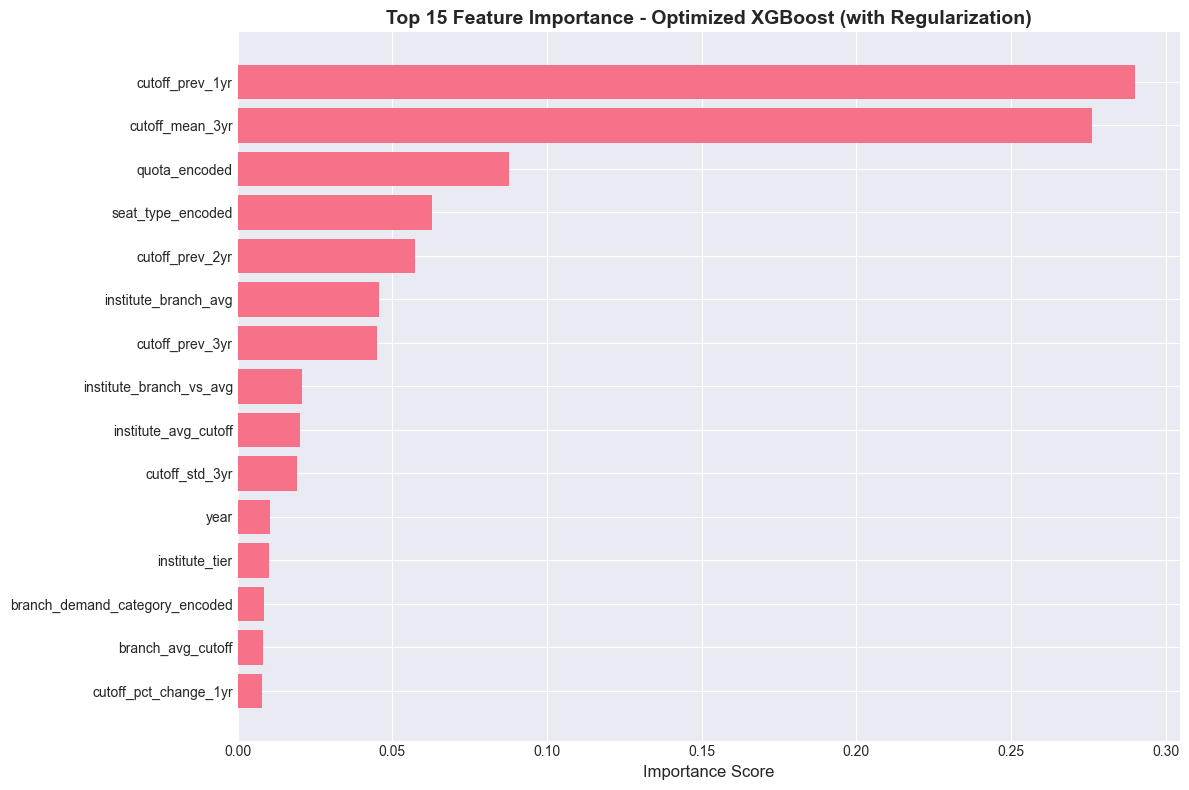


✅ Feature importance analysis completed!


In [142]:
# Get feature importance from the BEST model
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("📊 TOP 15 MOST IMPORTANT FEATURES")
print(f"   (from {best_model_name})")
print("="*80)
print(feature_importance.head(15).to_string(index=False))
print("="*80)

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title(f'Top 15 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis completed!")

## Step 12: Prediction Analysis - Actual vs Predicted

Visualize how well the model predicts cutoffs

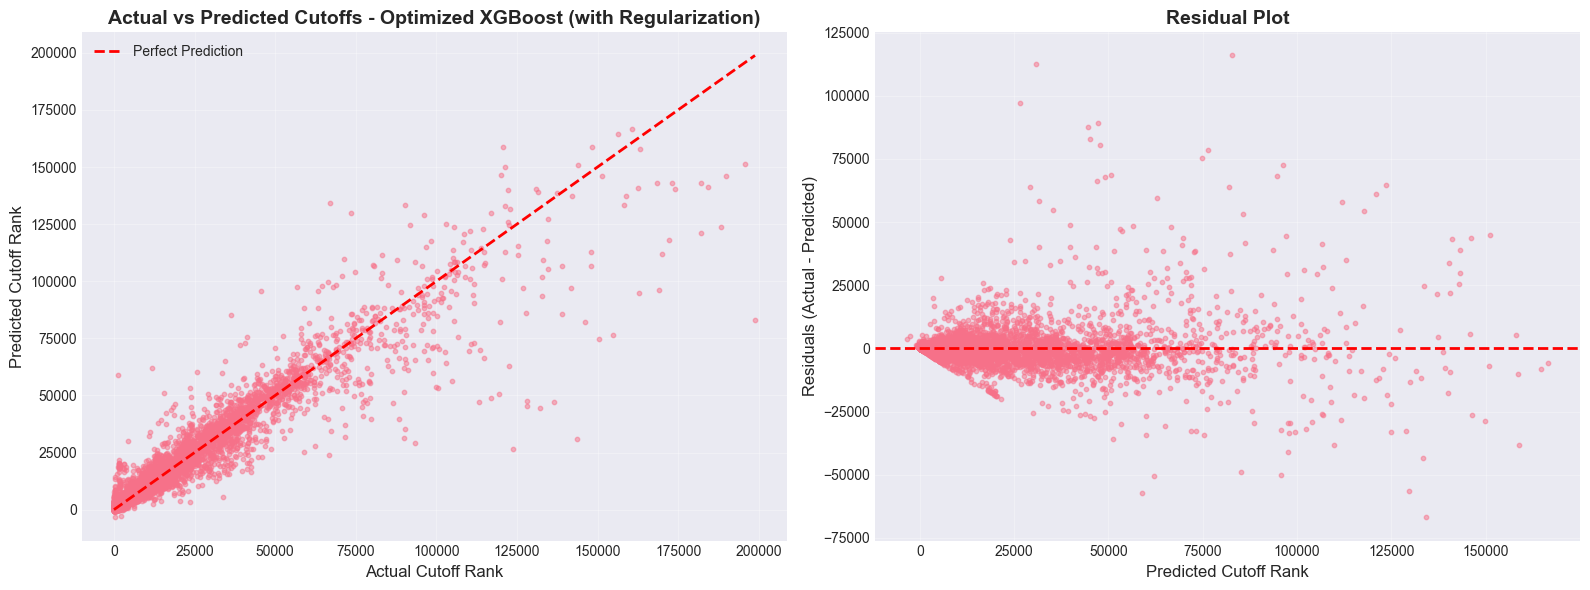

✅ Prediction visualization completed!


In [143]:
# Create visualization using BEST model predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs Predicted (Test Set)
axes[0].scatter(y_test, y_test_pred_best, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Cutoff Rank', fontsize=12)
axes[0].set_ylabel('Predicted Cutoff Rank', fontsize=12)
axes[0].set_title(f'Actual vs Predicted Cutoffs - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Residual plot
residuals = y_test - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Cutoff Rank', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Prediction visualization completed!")

## Step 13: Error Analysis by Category

Analyze model performance across different branches and institute tiers

In [144]:
# Create results dataframe for test set using BEST model
test_results = test_metadata.copy()
test_results['actual'] = y_test.values
test_results['predicted'] = y_test_pred_best
test_results['error'] = np.abs(y_test.values - y_test_pred_best)
test_results['pct_error'] = (test_results['error'] / test_results['actual'] * 100)

print("📊 ERROR ANALYSIS BY BRANCH")
print(f"   (using {best_model_name})")
print("="*80)
branch_errors = test_results.groupby('branch').agg({
    'error': ['mean', 'median', 'std'],
    'pct_error': 'mean',
    'actual': 'count'
}).round(2)
branch_errors.columns = ['MAE', 'Median Error', 'Std Error', 'MAPE %', 'Count']
branch_errors = branch_errors.sort_values('MAE', ascending=False).head(10)
print(branch_errors)

print("\n" + "="*80)
print("📊 BEST PERFORMING BRANCHES (Lowest Error)")
print("="*80)
best_branches = test_results.groupby('branch').agg({
    'error': 'mean',
    'actual': 'count'
}).round(2)
best_branches.columns = ['MAE', 'Count']
best_branches = best_branches[best_branches['Count'] >= 10].sort_values('MAE').head(10)
print(best_branches)

print("\n✅ Error analysis completed!")

📊 ERROR ANALYSIS BY BRANCH
   (using Optimized XGBoost (with Regularization))
                                     MAE  Median Error  Std Error  MAPE %  \
branch                                                                      
Bachelor of Design              26745.98      30546.98   11369.13  111.88   
Computational Mathematics       16075.58       5498.91   21692.26   64.61   
Food Engineering  and Technolo   9327.53       3726.48   14439.96   38.56   
Quantitative Economics & Data    9295.35       8222.73    7262.95   33.15   
B.Tech in Electronics & Commun   7013.44       7392.59    3229.90   44.07   
B.Tech in Aviation Engineering   5543.47       5553.98    3562.47   40.97   
Mathematics                      5465.85       1730.22    8188.99   50.43   
Material Science and Engineeri   5397.60       5162.21    4161.82   32.86   
SUSTAINABLE ENERGY TECHNOLOGIE   5043.20       3720.73    5054.82   35.67   
Electronic Engineering           4916.37       2427.10    7447.95   27.93  

## Step 14: Sample Predictions

Show some example predictions for different institutes and branches

In [145]:
# Show sample predictions
sample_results = test_results[['institute', 'branch', 'actual', 'predicted', 'error', 'pct_error']].copy()

print("📋 SAMPLE PREDICTIONS (Best Predictions)")
print("="*80)
print(sample_results.nsmallest(10, 'error').to_string(index=False))

print("\n" + "="*80)
print("📋 SAMPLE PREDICTIONS (Worst Predictions)")
print("="*80)
print(sample_results.nlargest(10, 'error').to_string(index=False))

print("\n" + "="*80)
print("📋 RANDOM SAMPLE PREDICTIONS")
print("="*80)
print(sample_results.sample(10).to_string(index=False))

📋 SAMPLE PREDICTIONS (Best Predictions)
                                               institute                         branch  actual   predicted    error  pct_error
                  Indian Institute  of Technology Madras                            CSE     4.0    3.993143 0.006857   0.171417
   Visvesvaraya National Institute of Technology, Nagpur                             EE   142.0  142.138458 0.138458   0.097506
                  Indian Institute  of Technology Kanpur                            CSE   117.0  116.761536 0.238464   0.203816
Indian Institute of Information Technology (IIIT) Ranchi                            ECE  7047.0 7047.270996 0.270996   0.003846
               Indian Institute  of Technology Hyderabad                            CSE   112.0  111.585281 0.414719   0.370284
          Indian Institute  of Technology (BHU) Varanasi Pharmaceutical Engineering & T  2363.0 2363.555908 0.555908   0.023526
   National Institute of Technology Karnataka, Surathkal        

## Step 15: Save the Trained Model

Save the model for future predictions and deployment

In [146]:
# Save the BEST model (either initial or optimized)
with open('xgboost_cutoff_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("✅ Model saved successfully!")
print(f"📁 File: xgboost_cutoff_model.pkl")
print(f"🏆 Model: {best_model_name}")

# Save model performance metrics
performance_metrics = {
    'model': best_model_name,
    'training_years': '2018-2023',
    'test_year': '2024',
    'test_mae': float(best_mae),
    'test_rmse': float(best_rmse),
    'test_r2': float(best_r2),
    'test_mape': float(best_mape),
    'n_features': len(feature_columns),
    'best_params': best_model.get_params()
}

import json
with open('model_performance.json', 'w') as f:
    json.dump(performance_metrics, f, indent=4, default=str)

print(f"\n✅ Performance metrics saved!")
print(f"📁 File: model_performance.json")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print(f"\n✅ Feature importance saved!")
print(f"📁 File: feature_importance.csv")

✅ Model saved successfully!
📁 File: xgboost_cutoff_model.pkl
🏆 Model: Optimized XGBoost (with Regularization)

✅ Performance metrics saved!
📁 File: model_performance.json

✅ Feature importance saved!
📁 File: feature_importance.csv


## Step 16: Model Summary Report

In [147]:
print("\n" + "="*80)
print("🎉 PHASE 3: MODEL BUILDING COMPLETED!")
print("="*80)

print("\n📊 FINAL MODEL SUMMARY")
print("="*80)
print(f"Model Type: {best_model_name}")
print(f"Training Data: 2018-2023 ({len(X_train):,} samples)")
print(f"Test Data: 2024 ({len(X_test):,} samples)")
print(f"Number of Features: {len(feature_columns)}")

print(f"\n🏆 MODEL PARAMETERS:")
# Show key parameters only
key_params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'min_child_weight', 'reg_alpha', 'reg_lambda']
for param in key_params:
    value = best_model.get_params().get(param)
    if value is not None:
        print(f"  {param}: {value}")

print(f"\n📈 PERFORMANCE METRICS (Test Set 2024):")
print(f"  Mean Absolute Error (MAE):  {best_mae:,.2f} ranks")
print(f"  Root Mean Squared Error:    {best_rmse:,.2f} ranks")
print(f"  R² Score:                   {best_r2:.4f}")
print(f"  Mean Absolute % Error:      {best_mape:.2f}%")

print(f"\n💡 INTERPRETATION:")
print(f"  - On average, predictions are off by {best_mae:,.0f} ranks")
print(f"  - Model explains {best_r2*100:.1f}% of variance in cutoffs")
print(f"  - Percentage error is {best_mape:.1f}% on average")

print(f"\n🔝 TOP 5 MOST IMPORTANT FEATURES:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\n📁 FILES CREATED:")
print(f"  1. xgboost_cutoff_model.pkl - Trained {best_model_name}")
print(f"  2. model_performance.json - Performance metrics")
print(f"  3. feature_importance.csv - Feature importance scores")

print("\n" + "="*80)
print("✅ Ready for Phase 4: Making Predictions!")
print("="*80)


🎉 PHASE 3: MODEL BUILDING COMPLETED!

📊 FINAL MODEL SUMMARY
Model Type: Optimized XGBoost (with Regularization)
Training Data: 2018-2023 (55,055 samples)
Test Data: 2024 (11,582 samples)
Number of Features: 21

🏆 MODEL PARAMETERS:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.05
  subsample: 0.8
  min_child_weight: 2
  reg_alpha: 0.1
  reg_lambda: 1

📈 PERFORMANCE METRICS (Test Set 2024):
  Mean Absolute Error (MAE):  2,222.74 ranks
  Root Mean Squared Error:    5,943.16 ranks
  R² Score:                   0.9125
  Mean Absolute % Error:      95.17%

💡 INTERPRETATION:
  - On average, predictions are off by 2,223 ranks
  - Model explains 91.3% of variance in cutoffs
  - Percentage error is 95.2% on average

🔝 TOP 5 MOST IMPORTANT FEATURES:
  cutoff_prev_1yr: 0.2902
  cutoff_mean_3yr: 0.2762
  quota_encoded: 0.0877
  seat_type_encoded: 0.0628
  cutoff_prev_2yr: 0.0574

📁 FILES CREATED:
  1. xgboost_cutoff_model.pkl - Trained Optimized XGBoost (with Regularization)
  2. model_per